In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, average_precision_score, fbeta_score
from sklearn.metrics import precision_recall_curve, roc_curve
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import json
import os

In [2]:
# Define ordinal encoding for birthweight and gestational age
bw = [
    '<500',
    '500-749',
    '750-999',
    '1000-1249',
    '1250-1499',
    '1500-1749',
     '1750-1999',
    '2000-2499',
    '>2500'
]
ga = [
    '<=24',
    '25-26',
    '27-28',
    '29-30',
    '31-32',
    '33-34',
    '35-36',
    '>36'
]

In [3]:
# Define CRIB-II score for sex, ga, bw
crib2 = {
    'M': {
        '<=24': {
            '<500': 14,
            '500-749': 13,
            '750-999': 11.5,
            '1000-1249': 11,
            '1250-1499': 11, #np.nan,
            '1500-1749': 11, #np.nan,
             '1750-1999': 11, #np.nan,
            '2000-2499': 11, #np.nan,
            '>2500': 11, #np.nan
        },
        '25-26': {
            '<500': 11.5,
            '500-749': 10.5,
            '750-999': 9,
            '1000-1249': 8.5,
            '1250-1499': 8,
            '1500-1749': 8, #np.nan,
             '1750-1999': 8, #np.nan,
            '2000-2499': 8, #np.nan,
            '>2500': 8, #np.nan,
        },
        '27-28': {
            '<500': 10,
            '500-749': 8.5,
            '750-999': 7,
            '1000-1249': 6.5,
            '1250-1499': 5.5,
            '1500-1749': 5.5,
             '1750-1999': 5.5, #np.nan,
            '2000-2499': 5.5, #np.nan,
            '>2500': 5.5, #np.nan
        },
        '29-30': {
            '<500': 8, #np.nan,
            '500-749': 8,
            '750-999': 6,
            '1000-1249': 4.5,
            '1250-1499': 3,
            '1500-1749': 2.5,
             '1750-1999': 2,
            '2000-2499': 2.5,
            '>2500': 2.5, #np.nan 
        },
        '31-32': {
            '<500': 8, #np.nan,
            '500-749': 8,
            '750-999': 6,
            '1000-1249': 3,
            '1250-1499': 1.5,
            '1500-1749': 0.5,
             '1750-1999': 0,
            '2000-2499': 0,
            '>2500': 0
        }
    },
    'F': {
        '<=24': {
            '<500': 13,
            '500-749': 12,
            '750-999': 10.5,
            '1000-1249': 10.5,
            '1250-1499': 10.5, #np.nan,
            '1500-1749': 10.5, #np.nan,
             '1750-1999': 10.5, #np.nan,
            '2000-2499': 10.5, #np.nan,
            '>2500': 10.5, #np.nan
        },
        '25-26': {
            '<500': 11,
            '500-749': 9.5,
            '750-999': 8.5,
            '1000-1249': 7.5,
            '1250-1499': 7,
            '1500-1749': 7, #np.nan,
             '1750-1999': 7, #np.nan,
            '2000-2499': 7, #np.nan,
            '>2500': 7, #np.nan
        },
        '27-28': {
            '<500': 10,
            '500-749': 8,
            '750-999': 6.5,
            '1000-1249': 5.5,
            '1250-1499': 4.5,
            '1500-1749': 5,
             '1750-1999': 5, #np.nan,
            '2000-2499': 5, #np.nan,
            '>2500': 5, #np.nan
        },
        '29-30': {
            '<500': 7,#np.nan,
            '500-749': 7,
            '750-999': 5,
            '1000-1249': 3.5,
            '1250-1499': 2.5,
            '1500-1749': 2,
             '1750-1999': 2,
            '2000-2499': 1,
            '>2500': 1, #np.nan
        },
        '31-32': {
            '<500': 7, #np.nan,
            '500-749': 7,
            '750-999': 5,
            '1000-1249': 3,
            '1250-1499': 1,
            '1500-1749': 0,
             '1750-1999': 0,
            '2000-2499': 0,
            '>2500': 0
        }
    }
}

In [4]:
select_labs = [
    'Base Excess',
    'pO2',
    'pCO2',
    'pH',
    'Hematocrit',
    'White Blood Cells',
    'Platelet Count',
]
features = [
    'ga',
    'bw',
    'gender',
    'Base Excess_valuenum',
    'pO2_valuenum',
    'pCO2_valuenum',
    'pH_valuenum',
    'Hematocrit_valuenum',
    'White Blood Cells_valuenum',
    'Platelet Count_valuenum',
    'Base Excess_count',
    'pO2_count',
    'pCO2_count',
    'pH_count',
    'Hematocrit_count',
    'White Blood Cells_count',
    'Platelet Count_count',
]
features_to_scale = [
    'ga_enc',
    'bw_enc',
    # 'gender_ga_bw',
    'Base Excess_valuenum',
    'pO2_valuenum',
    'pCO2_valuenum',
    'pH_valuenum',
    'Hematocrit_valuenum',
    'White Blood Cells_valuenum',
    'Platelet Count_valuenum',
    'Base Excess_count',
    'pO2_count',
    'pCO2_count',
    'pH_count',
    'Hematocrit_count',
    'White Blood Cells_count',
    'Platelet Count_count',
]

In [5]:
# base_values: ga, bw, sex, latest value for base excess
# base+arterial_values: ga, bw, sex, latest value for base excess, po2, pco2, ph
# base+arterial+blood_values: ga, bw, sex, latest value for base excess, po2, pco2, ph, hematocrit, white blood cells, platelet count
# base_counts: ga, bw, sex, count for base excess
# base+arterial_counts: ga, bw, sex, count for base excess, po2, pco2, ph
# base+arterial+blood_counts: ga, bw, sex, count for base excess, po2, pco2, ph, hematocrit, white blood cells, platelet count
# base_values_counts: ga, bw, sex, latest value and count for base excess
# base+arterial_values_counts: ga, bw, sex, latest value and count for base excess, po2, pco2, ph
# base+arterial+blood_values_counts: ga, bw, sex, latest value and count for base excess, po2, pco2, ph, hematocrit, white blood cells, platelet count

In [6]:
cohort = 'cohort_t12'
df = pd.read_csv(f'cohorts/{cohort}.csv')

In [7]:
cohort_name = cohort
feature_name = '-'
logdir = f'logs/{cohort_name}/{feature_name}'
logdir = None

In [8]:
# df = df[df['ga'].isin(ga)]

In [9]:
df['hospital_expire_flag'].value_counts()

hospital_expire_flag
0    1730
1      66
Name: count, dtype: int64

In [10]:
''' 
data_split: returns features (X) and labels (y) for three non-overlapping subsets of the given data frame
'''
def data_split(df, features, train_split, holdout_anchor_year_group):
    # Select specified features
    df = df[['subject_id', 'hospital_expire_flag', 'anchor_year_group'] + features]
    
    # Split dataset into training and testing subsets by time (de-identified temporal proxy is anchor_year_group, holdout on future samples)
    test_df = df[df['anchor_year_group'] == holdout_anchor_year_group].drop('anchor_year_group', axis=1)
    train_df = df[df['anchor_year_group'] != holdout_anchor_year_group].drop('anchor_year_group', axis=1)
    
    # Split data frames into features and labels
    X = train_df.drop(['subject_id', 'hospital_expire_flag'], axis=1)
    X_test = test_df.drop(['subject_id', 'hospital_expire_flag'], axis=1)
    y = train_df['hospital_expire_flag']
    y_test = test_df['hospital_expire_flag']

    # Split training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1-train_split, random_state=42, stratify=y)

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = data_split(df, features, train_split=0.7, holdout_anchor_year_group='2017 - 2019')

In [11]:
print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

hospital_expire_flag
0    967
1     36
Name: count, dtype: int64
hospital_expire_flag
0    414
1     16
Name: count, dtype: int64
hospital_expire_flag
0    349
1     14
Name: count, dtype: int64


In [12]:
def impute_ga_bw(X):
    X[['bw', 'ga']] = X[['bw', 'ga']].replace('UNK', np.nan)
    X['bw_imp'] = X['bw'].fillna(X.groupby('ga')['bw'].transform(lambda x: x[x.notna()].mode().iloc[0]))
    X['ga_imp'] = X['ga'].fillna(X.groupby('bw')['ga'].transform(lambda x: x[x.notna()].mode().iloc[0]))
    X = X.drop(['bw', 'ga'], axis=1)
    return X

In [13]:
def encode_ga_bw(X, bw, ga):
    bw_encoding = {bucket: idx for idx, bucket in enumerate(bw)}
    ga_encoding = {bucket: idx for idx, bucket in enumerate(ga)}
    X['bw_enc'] = X['bw_imp'].map(bw_encoding)
    X['ga_enc'] = X['ga_imp'].map(ga_encoding)
    X = X.drop(['bw_imp', 'ga_imp'], axis=1)
    return X

In [14]:
def encode_gender(X):
    X['gender'] = X['gender'].apply(lambda x: 1 if x == 'M' else 0)
    return X

In [15]:
def crib2_gender_ga_bw(x):
    return crib2[x['gender']][x['ga_imp']][x['bw_imp']]

def encode_crib2_gender_ga_bw(X):
    X['gender_ga_bw'] = X.apply(crib2_gender_ga_bw, axis=1)
    X = X.drop(['gender', 'ga_imp', 'bw_imp'], axis=1)
    return X

In [16]:
def crib2_base_excess(x):
    if x < -26: return 7
    elif x <= -23: return 6
    elif x <= -18: return 5
    elif x <= -13: return 4
    elif x <= -8: return 3
    elif x <= -3: return 2
    elif x <= 2: return 1
    elif x >= 3: return 0

def encode_crib2_base_excess(X):
    X['Base Excess_valuenum'] = X['Base Excess_valuenum'].apply(crib2_base_excess)
    return X

In [17]:
def impute_lab_values(X, select_labs):
    for lab in select_labs:
        lab_col = f'{lab}_valuenum'
        if lab_col in X: X[lab_col] = X[lab_col].fillna(X[lab_col].mean())
    return X
    
def impute_lab_flags(X, select_labs):
    for lab in select_labs:
        lab_col = f'{lab}_flag'
        if lab_col in X: X[lab_col] = X[lab_col].fillna('normal')
    return X

In [18]:
def fit_scale(X, scaler, features_to_scale):
    X[features_to_scale] = scaler.fit_transform(X[features_to_scale])

def scale(X, scaler, features_to_scale):
    X[features_to_scale] = scaler.transform(X[features_to_scale])

In [19]:
def smote(X, y, sampling_strategy=0.3):
    smote = SMOTE(sampling_strategy=sampling_strategy) 
    X_upsampled, y_upsampled = smote.fit_resample(X, y)
    return X_upsampled, y_upsampled

In [20]:
def preprocess_pipeline(X, scaler, train=True):
    X = impute_ga_bw(X)
    X = encode_ga_bw(X, bw, ga)
    X = encode_gender(X)
    X = impute_lab_values(X, select_labs)
    if train: fit_scale(X, scaler, features_to_scale)
    else: scale(X, scaler, features_to_scale)
    return X

# def preprocess_pipeline(X, scaler, train=True):
#     X = impute_ga_bw(X)
#     X = encode_crib2_gender_ga_bw(X)
#     X = impute_lab_values(X, select_labs)
#     X = encode_crib2_base_excess(X)
#     if train: fit_scale(X, scaler, features_to_scale)
#     else: scale(X, scaler, features_to_scale)
#     return X

In [21]:
scaler = StandardScaler()
X_train = preprocess_pipeline(X_train, scaler, train=True)
X_val = preprocess_pipeline(X_val, scaler, train=False)
X_test = preprocess_pipeline(X_test, scaler, train=False)

In [22]:
# X_train, y_train = smote(X_train, y_train, sampling_strategy=0.3)

In [23]:
print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

hospital_expire_flag
0    967
1     36
Name: count, dtype: int64
hospital_expire_flag
0    414
1     16
Name: count, dtype: int64
hospital_expire_flag
0    349
1     14
Name: count, dtype: int64


In [24]:
def train_eval(model, X_train, y_train, X_val, y_val, X_test, y_test, sample_weight=None, verbose=True, logdir=None, logfile=None):
    if sample_weight is None: model.fit(X_train, y_train)
    else: model.fit(X_train, y_train, sample_weight=sample_weight)
    eval(model, X_train, y_train, X_val, y_val, X_test, y_test, verbose, logdir, logfile)

def eval_metrics(model, X, y, split=None, verbose=True):
    if split: print(f'{split}:\n')
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:,1]
    accuracy = accuracy_score(y, y_pred)
    auroc = roc_auc_score(y, y_prob)
    aucpr = average_precision_score(y, y_prob)
    f2 = fbeta_score(y, y_pred, beta=2, average='binary')
    report = classification_report(y, y_pred, output_dict=True)
    recall_died = report['1']['recall']
    if verbose:
        print('Accuracy:', accuracy)
        print('AUROC:', auroc)
        print('AUCPR:', aucpr)
        print('F2:', f2)
        print('Classification Report:\n', classification_report(y, y_pred))
    return {
        'accuracy': accuracy,
        'auroc': auroc,
        'aucpr': aucpr,
        'recall_died': recall_died,
        'f2': f2,
        'report': report,
    }

def eval(model, X_train, y_train, X_val, y_val, X_test, y_test, verbose=True, logdir=None, logfile=None):
    logs = {}
    logs['training'] = eval_metrics(model, X_train, y_train, split='Training', verbose=verbose)
    logs['validation'] = eval_metrics(model, X_val, y_val, split='Validation', verbose=verbose)
    logs['testing'] = eval_metrics(model, X_test, y_test, split='Testing', verbose=verbose)
    if logfile and logdir:
        os.makedirs(logdir, exist_ok=True)
        logfile_path = os.path.join(logdir, logfile)
        with open(logfile_path, 'w') as f:
            json.dump(logs, f, indent=4)

In [25]:
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
    plt.figure(figsize=(8, 4))
    plt.barh(feature_names, importances)
    plt.xlabel('Gini Importance')
    plt.title('Feature Importance - Gini Importance')
    plt.gca().invert_yaxis()
    plt.show()

def plot_shapley(model, X_val):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val)
    shap_values_dead = shap_values[..., 1]
    shap.summary_plot(shap_values_dead, features=X_val, feature_names=X_val.columns)

In [44]:
def plot_pr_curve(y_true, y_pred_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve")
    plt.grid(True)
    plt.show()

In [26]:
model = LogisticRegression(penalty='l2', solver='liblinear')
train_eval(model, X_train, y_train, X_val, y_val, X_test, y_test, logdir=logdir, logfile='baseline_lr.json')

Training:

Accuracy: 0.967098703888335
AUROC: 0.9244513386188671
AUCPR: 0.46325467098437195
F2: 0.19607843137254902
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       967
           1       0.67      0.17      0.27        36

    accuracy                           0.97      1003
   macro avg       0.82      0.58      0.62      1003
weighted avg       0.96      0.97      0.96      1003

Validation:

Accuracy: 0.9651162790697675
AUROC: 0.8573369565217391
AUCPR: 0.33087311252482016
F2: 0.21739130434782608
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       414
           1       0.60      0.19      0.29        16

    accuracy                           0.97       430
   macro avg       0.78      0.59      0.63       430
weighted avg       0.96      0.97      0.96       430

Testing:

Accuracy: 0.9641873278236914
AUROC: 0.956815390912812

In [27]:
model = LogisticRegression(class_weight='balanced', penalty='l2', solver='liblinear')
train_eval(model, X_train, y_train, X_val, y_val, X_test, y_test, logdir=logdir, logfile='lr.json')

Training:

Accuracy: 0.8364905284147557
AUROC: 0.9311157072273928
AUCPR: 0.3856962833559274
F2: 0.4881656804733728
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91       967
           1       0.17      0.92      0.29        36

    accuracy                           0.84      1003
   macro avg       0.58      0.88      0.60      1003
weighted avg       0.97      0.84      0.89      1003

Validation:

Accuracy: 0.8325581395348837
AUROC: 0.8118961352657005
AUCPR: 0.27545885697030376
F2: 0.4166666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91       414
           1       0.15      0.75      0.25        16

    accuracy                           0.83       430
   macro avg       0.57      0.79      0.58       430
weighted avg       0.96      0.83      0.88       430

Testing:

Accuracy: 0.8622589531680441
AUROC: 0.917519443307409
A

In [28]:
# Logistic regression feature importance
feature_names = X_train.columns
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance['Absolute_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False)
print(feature_importance)

                       Feature  Coefficient  Absolute_Coefficient
3                pCO2_valuenum    -1.836952              1.836952
4                  pH_valuenum    -1.361029              1.361029
15                      bw_enc    -0.946841              0.946841
0                       gender    -0.756764              0.756764
9                    pO2_count     0.654943              0.654943
13     White Blood Cells_count     0.591586              0.591586
6   White Blood Cells_valuenum    -0.453336              0.453336
7      Platelet Count_valuenum     0.301302              0.301302
2                 pO2_valuenum    -0.259909              0.259909
1         Base Excess_valuenum     0.230018              0.230018
16                      ga_enc    -0.229174              0.229174
8            Base Excess_count    -0.210337              0.210337
5          Hematocrit_valuenum    -0.194365              0.194365
10                  pCO2_count     0.180495              0.180495
12        

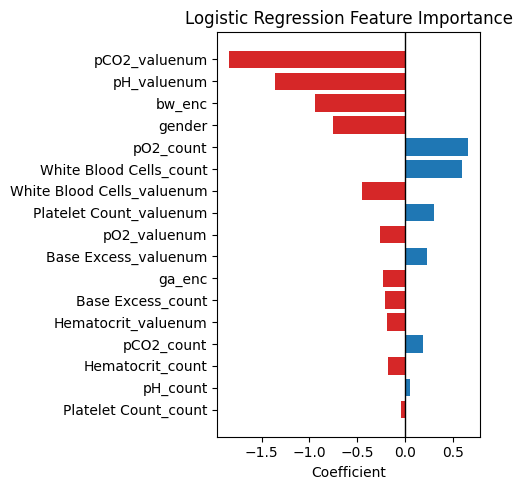

In [29]:
plt.figure(figsize=(5, 5))
feature_importance = feature_importance.sort_values(by='Absolute_Coefficient', ascending=True)
colors = feature_importance["Coefficient"].apply(
    lambda x: "tab:blue" if x > 0 else "tab:red"
)

plt.barh(
    feature_importance["Feature"],
    feature_importance["Coefficient"],
    color=colors
)

plt.axvline(0, color="black", linewidth=1)

plt.xlabel("Coefficient")
plt.title("Logistic Regression Feature Importance")
plt.tight_layout()
plt.show()

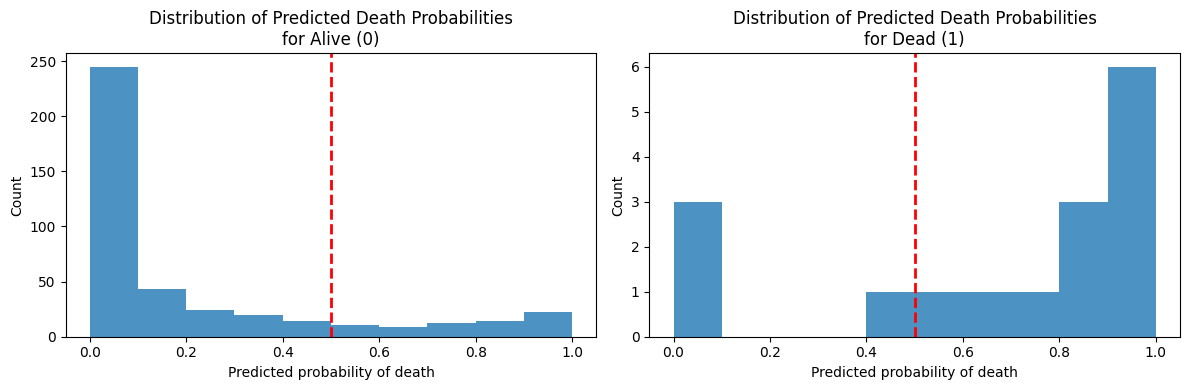

In [30]:
y_prob = model.predict_proba(X_val)[:,1]
prob_alive = y_prob[np.array(y_val) == 0]
prob_dead  = y_prob[np.array(y_val) == 1]
bins = [x*0.1 for x in range(0, 11)]
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(prob_alive, bins=bins, alpha=0.8, )
plt.axvline(x=0.5, color='r', linestyle='--', linewidth=2)
plt.title('Distribution of Predicted Death Probabilities\nfor Alive (0)')
plt.xlabel('Predicted probability of death')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
plt.hist(prob_dead, bins=bins, alpha=0.8)
plt.axvline(x=0.5, color='r', linestyle='--', linewidth=2)
plt.title('Distribution of Predicted Death Probabilities\nfor Dead (1)')
plt.xlabel('Predicted probability of death')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# TODO: merge the plots to make a stacked plot and show the threshold (0.5)

In [31]:
# sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)
# model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
# train_eval(model, X_train, y_train, X_val, y_val, X_test, y_test, sample_weight, logdir=logdir, logfile='xgb.json')

In [32]:
grid_search_scoring = 'recall'

In [33]:
param_grid = {
    'n_estimators': [10, 25, 50],
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 5],
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=grid_search_scoring, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

model = grid_search.best_estimator_

Best parameters: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Best score: 0.7821428571428573


In [34]:
eval(model, X_train, y_train, X_val, y_val, X_test, y_test, logdir=logdir, logfile='rf.json')

Training:

Accuracy: 0.8544366899302094
AUROC: 0.9338159255429163
AUCPR: 0.3874078115408631
F2: 0.49050632911392406
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92       967
           1       0.18      0.86      0.30        36

    accuracy                           0.85      1003
   macro avg       0.59      0.86      0.61      1003
weighted avg       0.96      0.85      0.90      1003

Validation:

Accuracy: 0.8465116279069768
AUROC: 0.9206672705314008
AUCPR: 0.3284295764823848
F2: 0.49295774647887325
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.91       414
           1       0.18      0.88      0.30        16

    accuracy                           0.85       430
   macro avg       0.59      0.86      0.61       430
weighted avg       0.96      0.85      0.89       430

Testing:

Accuracy: 0.8650137741046832
AUROC: 0.9643880474826033

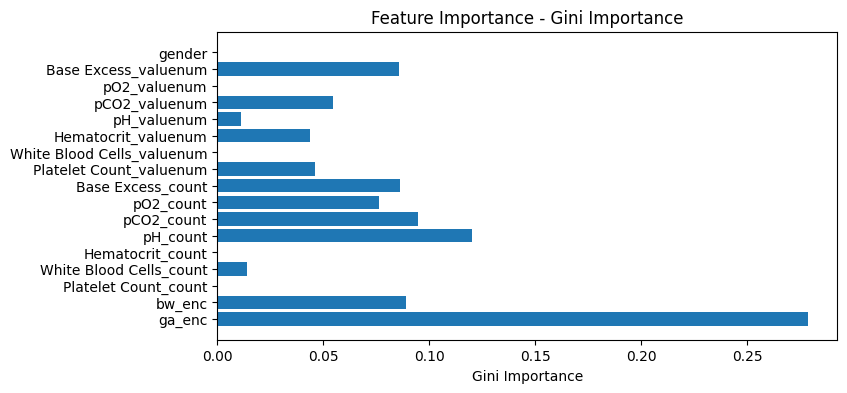

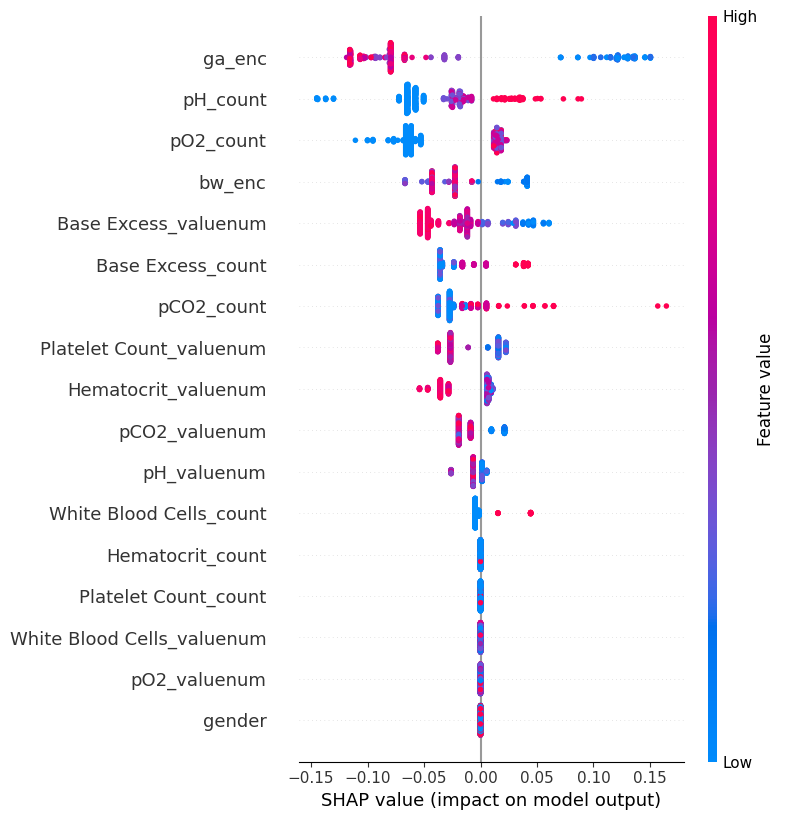

In [35]:
plot_feature_importance(model, X_val.columns)
plot_shapley(model, X_val)

In [38]:
brf = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [5, 10, 25, 50, 100],
    'max_depth': [None, 2, 5, 10, 20],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 5],
}

grid_search = GridSearchCV(brf, param_grid=param_grid, scoring=grid_search_scoring, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best parameters: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50}
Best score: 0.8107142857142857


In [39]:
eval(model, X_train, y_train, X_val, y_val, X_test, y_test, logdir=logdir, logfile='balanced_rf.json')

Training:

Accuracy: 0.8295114656031904
AUROC: 0.9494139951740779
AUCPR: 0.5011900820249501
F2: 0.4899135446685879
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.90       967
           1       0.17      0.94      0.28        36

    accuracy                           0.83      1003
   macro avg       0.58      0.88      0.59      1003
weighted avg       0.97      0.83      0.88      1003

Validation:

Accuracy: 0.8209302325581396
AUROC: 0.9131944444444444
AUCPR: 0.31171005280278286
F2: 0.4838709677419355
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.82      0.90       414
           1       0.16      0.94      0.28        16

    accuracy                           0.82       430
   macro avg       0.58      0.88      0.59       430
weighted avg       0.97      0.82      0.87       430

Testing:

Accuracy: 0.8760330578512396
AUROC: 0.9555873925501432


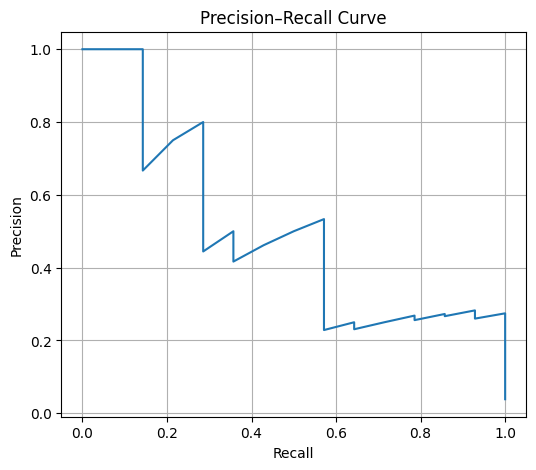

In [45]:
plot_pr_curve(y_test, model.predict_proba(X_test)[:, 1])

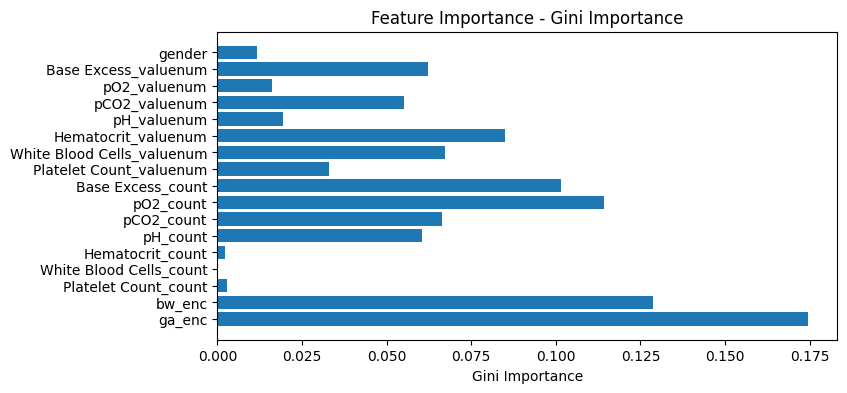

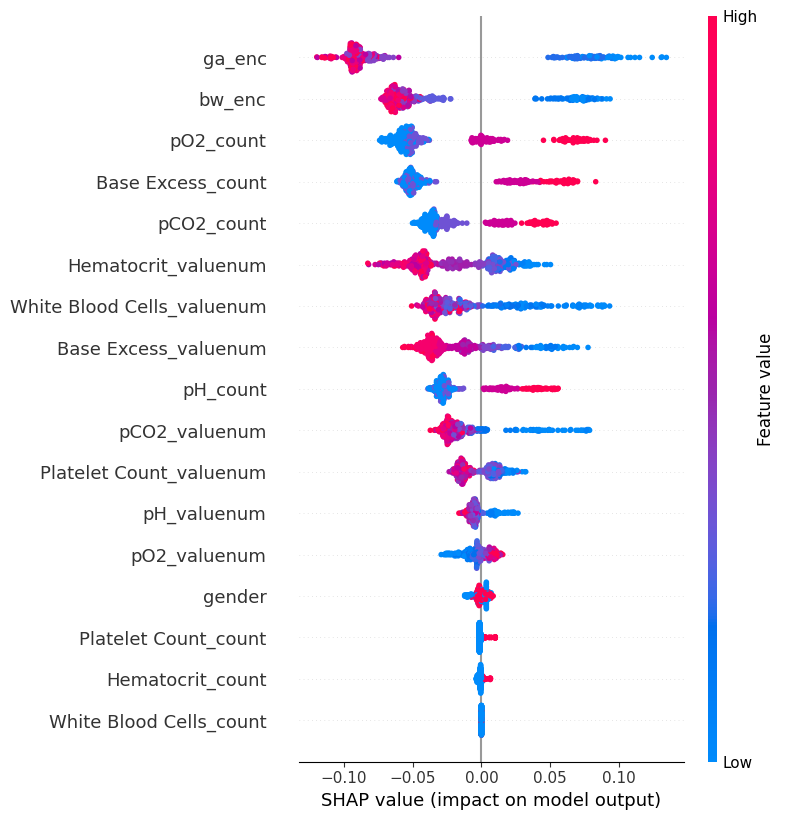

In [40]:
plot_feature_importance(model, X_val.columns)
plot_shapley(model, X_val)